In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
SEED = 147
# SEED = 258
# SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
import torch.optim as optim
from torch.utils import data

In [5]:
train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
test_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

train_dataset = datasets.FashionMNIST(root="../../../../_Datasets/FMNIST/", train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root="../../../../_Datasets/FMNIST/", train=False, download=True, transform=test_transform)

In [6]:
BS = 2000 #200
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BS, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BS, shuffle=False, num_workers=2)

In [7]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([2000, 1, 28, 28])

# Model

In [8]:
class MlpBLock(nn.Module):
    
    def __init__(self, dims, actf=nn.ReLU):
        super().__init__()
        self.dims = dims
        #### convert hidden layers ratio to list if integer is inputted
            
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.dims)-1):
            i, o = int(self.dims[h]),\
                    int(self.dims[h+1])
            self.mlp.append(nn.Linear(i, o))
#             self.mlp.append(nn.BatchNorm1d(o))
            self.mlp.append(
                nn.Sequential(
#                               nn.BatchNorm1d(o),
                              nn.Dropout(p=0.1),
                              nn.LayerNorm(o),
                              actf(),
                             )
                            )
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [9]:
MlpBLock([2, 3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (2): Linear(in_features=3, out_features=4, bias=True)
  )
)

## Graph Creation Practice

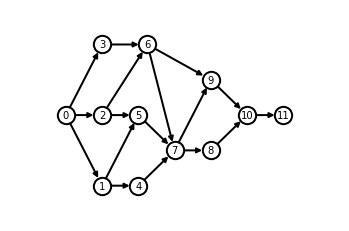

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 3)
G.add_edge(1, 4)
G.add_edge(1, 5)
G.add_edge(2, 5)
G.add_edge(2, 6)
G.add_edge(3, 6)
G.add_edge(4, 7)
G.add_edge(5, 7)
G.add_edge(6, 7)
G.add_edge(7, 8)
G.add_edge(7, 9)
G.add_edge(6, 9)
G.add_edge(8, 10)
G.add_edge(9, 10)
G.add_edge(10, 11)


# explicitly set positions
pos = {0: (0, 1), 
       1: (1, 0), 
       2: (1, 1), 
       3: (1, 2), 
       4: (2, 0),
       5: (2, 1),
       6: (2.25, 2),
       7: (3, 0.5),
       8: (4, 0.5),
       9: (4, 1.5),
       10: (5, 1),
       11: (6, 1),
      }

options = {
    "font_size": 10,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw_networkx(G, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [11]:
G.edges

OutEdgeView([(0, 1), (0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 7), (5, 7), (6, 7), (6, 9), (7, 8), (7, 9), (8, 10), (9, 10), (10, 11)])

In [12]:
G.in_degree(), G.out_degree()

(InDegreeView({0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 1, 9: 2, 10: 2, 11: 1}),
 OutDegreeView({0: 3, 1: 2, 2: 2, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 1, 9: 1, 10: 1, 11: 0}))

In [13]:
G.out_edges

OutEdgeView([(0, 1), (0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 7), (5, 7), (6, 7), (6, 9), (7, 8), (7, 9), (8, 10), (9, 10), (10, 11)])

In [14]:
G.in_edges

InEdgeView([(0, 1), (0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 7), (5, 7), (6, 7), (7, 8), (7, 9), (6, 9), (8, 10), (9, 10), (10, 11)])

## Block Dimension-Mixer 

1. `Local Models` are the basis for local training of models.
2. `Local Models` have their own optimizer and communicate via low bandwidth connection.
3. This experiment verifies if training local models reduces the number of forward and backward pass for reaching the solution.
4. The main idea is to update local model multiple times and backproping the final gradient, rather than doing it one iteration (similar to higher order optimization ?? like 1.5-nd optimization)
5. The optimal spectrum lies in between (Its like dynamic optimization, while doing inference with more communication between local models, far away models communicate less). There has been similar ideas otherwhere as well but not exactly. Its based on my own experiment using optimizer for find better gradient for global optimizer.

In [15]:
### temp herer
xx = torch.randn(5, 3)
dys = [torch.randn(5, 2), torch.randn(5,2)]

In [16]:
import abc

In [17]:
class DistributedNode(abc.ABC):
#     @abc.abstractmethod
    def set_input_nodes(self, nodes):
        pass
    
#     @abc.abstractmethod
    def set_output_nodes(self, nodes):
        pass
    
#     @abc.abstractmethod
    def forward_local(self):
        pass
    
#     @abc.abstractmethod
    def backward_local(self):
        pass
    
#     @abc.abstractmethod
    def update_local(self):
        pass
    
#     @abc.abstractmethod
#     def train_loop(self, ):
#         pass

In [18]:
import copy

In [19]:
class LocalModel(DistributedNode):
    
    def __init__(self, model, lr=0.001, local_lr=0.003, local_updates=100):
        self.model = model
        self.lr = lr
#         self.optimizer = None
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.local_lr = local_lr
        self.local_updates = local_updates
        
        self.output_dim = model.dims[-1]
        self.split_indices = None
        
        ### temporary state variables
        self.input_received = []
        self.input_shapes = []
        self.output_shape = None
        self.grad_received = None
        ######## testing target
        self.target = None
        
        #### For storing local variables
        
    def set_split_mixing_indices(self, split_sizes=None):
        if split_sizes is None:
            split_sizes = [self.output_dim, ]
        ## split sizes added must be >= to input size
        assert self.output_dim <= np.sum(split_sizes), "split sizes are less than input dimension"
        for ss in split_sizes:
            assert self.output_dim >= ss, "split sizes are greater than input dimension"
            
        
        ## also do not use split sizes greater than input dimension
        
        indices = np.arange(0, self.output_dim, 1, dtype=int)
        indices = np.random.permutation(indices)
        
        ## first divide input dimension into all splits
        split_loc = split_sizes/np.sum(split_sizes)*self.output_dim
        split_loc = split_loc.astype(int)
        split_loc[0] += self.output_dim-split_loc.sum()
        
        index = np.split(indices, np.cumsum(split_loc[:-1]))
        ## for extra input dimensions, sample randomly from remaining node indices.
        for i in range(len(index)):
            idx = index[i]
            mask = np.ones(self.output_dim, dtype=bool)
            mask[idx] = False
            remaining = np.arange(0, self.output_dim, 1, dtype=int)[mask]
            num_remain = split_sizes[i] - len(idx)
            new_idx = remaining[np.random.permutation(len(remaining))[:num_remain]]
            new_idx = np.array(new_idx)
            
            all_inx = np.concatenate((idx, new_idx))
            index[i] = torch.LongTensor(all_inx)
            pass
        
        self.split_indices = index
        pass
        
        
    def forward(self, x):
        return self.model(x)
        
    @torch.no_grad()
    def forward_local(self, xs):
        ### concat received inputs
        self.input_shapes = [xi.shape for xi in xs]
        xs = torch.cat(xs, dim=1)
        
        self.input_received = xs.data

        xs = self.model(xs)
        self.output_shape = xs.shape
        
        ys = []
        for si in self.split_indices:
            ys.append(xs[:, si])

#         .split([100, 100], dim=1)
        return ys
    
    def backward_local(self, dys):
        ### concat received gradients
        with torch.no_grad():
            
            grads = torch.zeros(self.output_shape).to(dys[0].device)
            for i, si in enumerate(self.split_indices):
                grads[:,si] += dys[i]

            self.grad_received = grads

        ### Set input gradients and target
        Xs = nn.Parameter(self.input_received, requires_grad=True)
        ys = self.model(Xs)
        Xgrad = torch.autograd.grad(ys, Xs, self.grad_received, only_inputs=True)[0]
        
        split_sz = [t[-1] for t in self.input_shapes]
        input_grads = Xgrad.split(split_sz, dim=1)
        
#         self.target = ys.data - self.grad_received.data*10
        self.target = ys.data - grads.data*100.0

        ####### Train the local network
        
#         criterion = nn.MSELoss()
        def criterion(y, t):
            return (0.5*(y-t)**2).sum()

#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.99))
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
#         self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.001)
            
        ### get model gradients different way
        for epoch in range(100): ### Extra steps for optimizing using the same target
            ys = self.model(self.input_received)
            loss = criterion(ys, self.target)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return input_grads



###### optimize using the same model and parameters
##### save gradient norm, optimize copy model and gather gradient from there
##### normalize the gradients to original gradient norm
#     def backward_local(self, dys):
#         ### concat received gradients
#         with torch.no_grad():
            
#             grads = torch.zeros(self.output_shape).to(dys[0].device)
#             for i, si in enumerate(self.split_indices):
#                 grads[:,si] += dys[i]

#             self.grad_received = grads

# #         criterion = nn.MSELoss()
#         def criterion(y, t):
#             return (0.5*(y-t)**2).sum()

#         Xs = nn.Parameter(self.input_received, requires_grad=True)
#         ys = self.model(Xs)
#         Xgrad = torch.autograd.grad(ys, Xs, self.grad_received, only_inputs=True)[0]
#         split_sz = [t[-1] for t in self.input_shapes]
#         input_grads = Xgrad.split(split_sz, dim=1)
        
#         self.target = ys.data - grads.data*10.0

#         new_model = copy.deepcopy(self.model)
#         new_model.load_state_dict(self.model.state_dict())
#         new_optim = torch.optim.Adam(new_model.parameters(), lr=0.001)
            
#         ### get model gradients different way
#         for epoch in range(40): ### Extra steps for optimizing using the same target
#             ys = new_model(self.input_received)
#             loss = criterion(ys, self.target)
            
#             new_optim.zero_grad()
#             loss.backward()
#             new_optim.step()
# #             if epoch == 0:
# #                 for parm in new_model.parameters():
# #                     parm.grad_norm = torch.norm(parm.grad)
            
#        ### get unlooped optimizer
#         for parm, new_parm in zip(self.model.parameters(), new_model.parameters()):
# #             print(parm.grad, torch.norm(parm.grad))
#             ## normalize the norm of the gradients according to original
#             parm.grad = - (new_parm.data - parm.data) 
#             ### normalize it to the ratio of initial gradient magnitude
# #             print(parm.grad, torch.norm(parm.grad), new_parm.grad_norm)
# #             parm.grad = parm.grad/(torch.norm(parm.grad)+1e-7)*new_parm.grad_norm
            
# #         self.model = bkp_model

#         self.optimizer.step()
#         self.optimizer.zero_grad()
# #         print(torch.norm(input_grads[0]), torch.norm(self.grad_received))
#         return input_grads

In [20]:
lm = LocalModel(MlpBLock([3, 5, 3]))

In [21]:
lm.set_split_mixing_indices([2, 2])
# lm.set_split_mixing_indices(None)

In [22]:
lm.split_indices

[tensor([1, 0]), tensor([2, 0])]

In [23]:
lm.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [24]:
lm.forward_local([xx])

[tensor([[ 0.2331, -0.2543],
         [ 0.0391, -0.5917],
         [ 0.4029,  0.0740],
         [ 0.4068,  0.1419],
         [ 0.1493, -0.3278]]),
 tensor([[ 0.1190, -0.2543],
         [ 0.8903, -0.5917],
         [ 0.0491,  0.0740],
         [-0.0637,  0.1419],
         [-0.5916, -0.3278]])]

In [25]:
# dys = [torch.randn(2, 2), torch.randn(2,2)]
# dys = [torch.randn(2, 3),]

lm.backward_local(dys)

(tensor([[ 6.5701e-01, -7.9034e-01, -6.6066e-02],
         [-1.0337e-01,  5.4641e-04,  6.7159e-02],
         [-8.0819e-02, -9.5132e-02,  1.0195e-01],
         [-7.1411e-02, -1.2860e-01,  1.7697e-01],
         [ 5.1456e-01, -8.2910e-01, -2.1784e-01]]),)

In [26]:
lm.grad_received

tensor([[-1.8900, -0.5039, -0.2272],
        [ 0.5311, -1.0748, -0.4435],
        [ 0.5373, -0.2330, -0.4374],
        [ 0.5096,  0.3480, -0.1747],
        [-2.1820,  0.3810,  0.0455]])

In [27]:
for p in lm.model.parameters():
    print(p.grad)

tensor([[ 168.7123,   10.1176,  100.2327],
        [  69.5839,    2.8755,  -42.8336],
        [ -26.8998,  -54.5045,  179.6676],
        [ -76.6733,   70.5378, -254.7096],
        [  12.2818,  -21.5869,    1.1647]])
tensor([  38.0674,  -74.8231,  148.6718, -172.9162,  -33.8603])
tensor([ -85.7599,   -5.7722,   16.8763, -173.3475,    0.0000])
tensor([ -64.7278,  -18.6866,   11.8642, -114.1957,    0.0000])
tensor([[  13.9507,   18.9250, -243.9871, -403.7310,    0.0000],
        [-213.8820,   13.0969,   43.3936, -156.5489,    0.0000],
        [-183.1409,   -6.1221,    5.1912, -135.1819,    0.0000]])
tensor([-248.2108, -106.6114, -121.1515])


In [28]:
p

Parameter containing:
tensor([-0.1642,  0.1093,  0.4060], requires_grad=True)

In [29]:
lm.optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[ 0.0300,  0.5263,  0.0720],
         [ 0.1730, -0.1940, -0.4410],
         [ 0.3676, -0.5382,  0.4060],
         [-0.0271,  0.3004,  0.5185],
         [ 0.3714, -0.1462,  0.3122]], requires_grad=True),
 Parameter containing:
 tensor([ 0.5511,  0.4164,  0.2994,  0.4824, -0.2428], requires_grad=True),
 Parameter containing:
 tensor([1.1079, 1.0334, 0.9216, 1.0859, 0.9991], requires_grad=True),
 Parameter containing:
 tensor([ 0.1042,  0.0573, -0.0815,  0.0918, -0.0040], requires_grad=True),
 Parameter containing:
 tensor([[-0.1207, -0.4735, -0.0854,  0.4550,  0.0338],
         [ 0.1162,  0.3133, -0.1003,  0.3583,  0.2393],
         [ 0.4119,  0.3557, -0.4095, -0.3005,  0.1493]], requires_grad=True),
 Parameter containing:
 tensor([-0.1642,  0.1093,  0.4060], requires_grad=True)]

In [30]:
lm.optimizer.state

defaultdict(dict,
            {Parameter containing:
             tensor([[ 0.0300,  0.5263,  0.0720],
                     [ 0.1730, -0.1940, -0.4410],
                     [ 0.3676, -0.5382,  0.4060],
                     [-0.0271,  0.3004,  0.5185],
                     [ 0.3714, -0.1462,  0.3122]], requires_grad=True): {'step': 100,
              'exp_avg': tensor([[ 1.4875e+02, -9.2698e+00,  7.5909e+01],
                      [ 5.1134e+01, -1.7063e+01, -2.9218e+01],
                      [-9.5448e+00, -2.6787e+01,  1.6239e+02],
                      [-1.2883e+02,  6.2780e+01, -2.0242e+02],
                      [-2.4303e+01, -1.4703e+01,  8.1203e-02]]),
              'exp_avg_sq': tensor([[2316.6006,  221.5443,  605.4173],
                      [ 221.6372,  323.3701,  121.8838],
                      [ 238.8378,  208.8795, 3019.1292],
                      [1913.5464,  508.2268, 5321.3804],
                      [ 205.3705,   66.3730,   68.3708]])},
             Parameter containi

In [31]:
xx = torch.randn(5, 3)
dys = [torch.randn(5, 2), torch.randn(5,2)]

In [32]:
# None
# tensor([[-0.0216, -0.0131, -0.0257],
#         [-0.0267, -0.0162, -0.0317],
#         [ 2.6498,  1.6019,  3.1403],
#         [-0.1429, -0.0864, -0.1694],
#         [ 0.9580,  0.5792,  1.1354]])
# None
# tensor([ 0.0157,  0.0194, -1.9184,  0.1035, -0.6936])
# None
# tensor([[ 0.0912, -0.0091,  1.3586, -0.3357, -0.0134],
#         [-0.2009,  0.0201, -2.9941,  0.7397,  0.0295],
#         [-0.0647,  0.0065, -0.9643,  0.2382,  0.0095]])
# None
# tensor([ 2.4200, -5.3331, -1.7176])
# ----------
# tensor([[-0.0216, -0.0131, -0.0257],
#         [-0.0267, -0.0162, -0.0317],
#         [ 2.6498,  1.6019,  3.1403],
#         [-0.1429, -0.0864, -0.1694],
#         [ 0.9580,  0.5792,  1.1354]])
# tensor([ 0.0157,  0.0194, -1.9184,  0.1035, -0.6936])
# tensor([[ 0.0912, -0.0091,  1.3586, -0.3357, -0.0134],
#         [-0.2009,  0.0201, -2.9941,  0.7397,  0.0295],
#         [-0.0647,  0.0065, -0.9643,  0.2382,  0.0095]])
# tensor([ 2.4200, -5.3331, -1.7176])
# (tensor([[-0.6782,  0.9934,  0.2818]]),)

In [33]:
class DataFeeder(DistributedNode):
    
    def __init__(self, input_dim, split_sizes = []):
        super().__init__()
        self.input_dim = input_dim
        self.split_sizes = np.array(split_sizes, dtype=int)
        self.split_indices = None

        self.inputs = None
        self.output_nodes = None
        
        ## preprocessing steps
        self._set_split_mixing_indices_()
        
    def _set_split_mixing_indices_(self):
        ## split sizes added must be >= to input size
        assert self.input_dim <= np.sum(self.split_sizes), "split sizes are less than input dimension"
        for ss in self.split_sizes:
            assert self.input_dim >= ss, "split sizes are greater than input dimension"
            
        
        ## also do not use split sizes greater than input dimension
        
        indices = np.arange(0, self.input_dim, 1, dtype=int)
        indices = np.random.permutation(indices)
        
#         print(indices)
        ## first divide input dimension into all splits
        split_indices = self.split_sizes/np.sum(self.split_sizes)*self.input_dim
        split_indices = split_indices.astype(int)
        split_indices[0] += self.input_dim-split_indices.sum()
        print(split_indices, split_indices.sum())
        
        index = np.split(indices, np.cumsum(split_indices[:-1]))
#         for idx in index:
#             print(len(idx))
            
        ## for extra input dimensions, sample randomly from remaining node indices.
        for i in range(len(index)):
            idx = index[i]
            mask = np.ones(self.input_dim, dtype=bool)
            mask[idx] = False
            remaining = np.arange(0, self.input_dim, 1, dtype=int)[mask]
            num_remain = self.split_sizes[i] - len(idx)
            new_idx = remaining[np.random.permutation(len(remaining))[:num_remain]]
            new_idx = np.array(new_idx)
            
            all_inx = np.concatenate((idx, new_idx))
            index[i] = torch.LongTensor(all_inx)
            
        for idx in index:
            print(len(idx))
            
        self.split_indices = index
        pass

    def set_input(self, x):
        '''
        x is assumed to be 2D; --> BatchSize, Dimension
        '''
        sz = x.shape
        x = x.reshape(sz[0], -1)
        self.inputs = [None for _ in range(len(self.split_indices))]
        for i, si in enumerate(self.split_indices):
            self.inputs[i] = x[:, si.to(x.device)]
        return self.inputs
    
    def forward_local(self, x):
        return self.set_input(x)
    
    def backward_local(self, ):
        pass
    
    def update_local(self, ):
        pass

In [34]:
df = DataFeeder(784, [300, 300, 300])

[262 261 261] 784
300
300
300


In [35]:
class GraphDimMixerModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        ## defining model hardcoded
        self.m0 = DataFeeder(784, split_sizes=[300, 300, 300])
        
        self.m1 = MlpBLock([300, 600, 300])
        self.m2 = MlpBLock([300, 500, 250])
        self.m3 = MlpBLock([300, 500, 200])
        
        self.m4 = MlpBLock([150, 300, 100])
        self.m5 = MlpBLock([250, 400, 100])
        self.m6 = MlpBLock([350, 500, 200])
        self.m7 = MlpBLock([300, 500, 200])
        self.m8 = MlpBLock([100, 150, 50])
        self.m9 = MlpBLock([200, 300, 100])
        self.m10 = MlpBLock([150, 200, 10])
        
    def forward(self, x):
        x1, x2, x3 = self.m0.forward_local(x)
        x1 = self.m1(x1).split([150, 150], dim=1)
        x2 = self.m2(x2).split([100, 150], dim=1)
        x3 = self.m3(x3)
        
        x4 = x1[0]
        x5 = torch.cat([x1[1], x2[0]], dim=1)
        x6 = torch.cat([x2[1], x3], dim=1)
        x4 = self.m4(x4)
        x5 = self.m5(x5)
        x6 = self.m6(x6).split([100, 100], dim=1)
        
        x7 = torch.cat([x4, x5, x6[0]], dim=1)
        x7 = self.m7(x7).split([100, 100], dim=1)
#         print(x7[0].shape, x7[1].shape)
        x8 = x7[0]
        x8 = self.m8(x8)
        x9 = torch.cat([x6[1], x7[1]], dim=1)
        x9 = self.m9(x9)
        
        x10 = torch.cat([x9, x8], dim=1)
        x10 = self.m10(x10)
        return x10

In [36]:
# model = GraphDimMixerModel().to(device)
# model

In [37]:
class Dist_GraphDimMixerModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        ## defining model hardcoded
        self.m0 = DataFeeder(784, split_sizes=[300, 300, 300])
        
        self.m1 = LocalModel(MlpBLock([300, 600, 300]))
        self.m1.set_split_mixing_indices([150, 150])
        self.m2 = LocalModel(MlpBLock([300, 500, 250]))
        self.m2.set_split_mixing_indices([100, 150])
        self.m3 = LocalModel(MlpBLock([300, 500, 200]))
        self.m3.set_split_mixing_indices(None)
        
        self.m4 = LocalModel(MlpBLock([150, 300, 100]))
        self.m4.set_split_mixing_indices(None)
        self.m5 = LocalModel(MlpBLock([250, 400, 100]))
        self.m5.set_split_mixing_indices(None)
        self.m6 = LocalModel(MlpBLock([350, 500, 200]))
        self.m6.set_split_mixing_indices([100, 100])
        self.m7 = LocalModel(MlpBLock([300, 500, 200]))
        self.m7.set_split_mixing_indices([100, 100])
        self.m8 = LocalModel(MlpBLock([100, 150, 50]))
        self.m8.set_split_mixing_indices(None)
        self.m9 = LocalModel(MlpBLock([200, 300, 100]))
        self.m9.set_split_mixing_indices(None)
        self.m10 = LocalModel(MlpBLock([150, 200, 10]))
        self.m10.set_split_mixing_indices(None)
        
        self.model_list = [self.m1, self.m2, self.m3, self.m4, self.m5, 
                           self.m6, self.m7, self.m8, self.m9, self.m10]
        self.module_list = nn.ModuleList([m.model for m in self.model_list])
        
    def set_optimizer_with_device(self, device):
        for m in self.model_list:
            m.model.to(device)
#             m.optimizer = torch.optim.Adam(m.model.parameters(), lr=0.001)
            m.optimizer = torch.optim.SGD(m.model.parameters(), lr=0.3)
        pass
        
    def forward_local(self, x):
        x1, x2, x3 = self.m0.forward_local(x)
        x1 = self.m1.forward_local([x1])
        x2 = self.m2.forward_local([x2])
        x3 = self.m3.forward_local([x3])
        
        x4 = self.m4.forward_local([x1[0]])
        x5 = self.m5.forward_local([x1[1], x2[0]])
        
        x6 = self.m6.forward_local([x2[1], x3[0]])
        
        x7 = self.m7.forward_local([x4[0], x5[0], x6[0]])
        x8 = self.m8.forward_local([x7[0]])
        x9 = self.m9.forward_local([x6[1], x7[1]])
        
        x10 = self.m10.forward_local([x8[0], x9[0]])
        return x10[0]
    
    def backward_local(self, dy):
        d10 = self.m10.backward_local([dy])
        d9 = self.m9.backward_local([d10[1]])
        d8 = self.m8.backward_local([d10[0]])
        d7 = self.m7.backward_local([d8[0], d9[1]])
        d6 = self.m6.backward_local([d7[2], d9[0]])
        d5 = self.m5.backward_local([d7[1]])
        d4 = self.m4.backward_local([d7[0]])
        d3 = self.m3.backward_local([d6[1]])
        d2 = self.m2.backward_local([d5[1], d6[0]])
        d1 = self.m1.backward_local([d4[0], d5[0]])
        return

In [38]:
d_dimixer = Dist_GraphDimMixerModel().to(device)

[262 261 261] 784
300
300
300


In [39]:
d_dimixer

Dist_GraphDimMixerModel(
  (module_list): ModuleList(
    (0): MlpBLock(
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
        )
        (2): Linear(in_features=600, out_features=300, bias=True)
      )
    )
    (1): MlpBLock(
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=500, bias=True)
        (1): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
        )
        (2): Linear(in_features=500, out_features=250, bias=True)
      )
    )
    (2): MlpBLock(
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=500, bias=True)
        (1): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): LayerNorm((500,), eps=1e-05, 

In [40]:
d_dimixer.set_optimizer_with_device(device)

In [41]:
d_dimixer.forward_local(torch.randn(3, 784).to(device))

tensor([[-1.1805,  0.4887, -0.1379, -0.6295,  0.2024,  0.2400,  0.2682,  0.4283,
         -0.1800, -0.1663],
        [-0.8595,  0.2606,  0.0802, -0.2151,  0.0765, -0.0135, -0.1285, -0.0144,
         -0.4533, -0.0153],
        [-0.7711, -0.2518,  0.1469, -0.1327,  0.0648, -0.0886,  0.2752,  0.2179,
         -0.2622,  0.0588]], device='cuda:0')

In [42]:
d_dimixer.backward_local(torch.randn(3, 10).to(device))

In [43]:
# asdfsdf

### Distributed local model training Code

In [44]:
model = Dist_GraphDimMixerModel()
model.set_optimizer_with_device(device)

[262 261 261] 784
300
300
300


In [45]:
model_name = f'distrib_dim_mixer_fmist_s{SEED}'

In [46]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()

In [47]:
STAT ={'train_stat':[], 'test_stat':[]}

In [48]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.no_grad():
            outputs = model.forward_local(inputs)
        out = torch.autograd.Variable(outputs, requires_grad=True)
        loss = criterion(out, targets)
        loss.backward()
            
        model.backward_local(out.grad)
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [49]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.forward_local(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
#         state = {
#             'model': model.state_dict(),
#             'acc': acc,
#             'epoch': epoch
#         }
#         if not os.path.isdir('models'):
#             os.mkdir('models')
#         torch.save(state, f'./models/{model_name}.pth')
#         best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [50]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    
    STAT = checkpoint['stats']

In [51]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
#     scheduler.step()

100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 0 Loss: 1.699 | Acc: 61.287 36772/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[Test] 0 Loss: 1.075 | Acc: 77.430 7743/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 1 Loss: 1.002 | Acc: 81.408 48845/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


[Test] 1 Loss: 0.794 | Acc: 83.410 8341/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.23s/it]


[Train] 2 Loss: 0.723 | Acc: 85.722 51433/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[Test] 2 Loss: 0.615 | Acc: 85.880 8588/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 3 Loss: 0.554 | Acc: 87.712 52627/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


[Test] 3 Loss: 0.514 | Acc: 86.810 8681/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 4 Loss: 0.457 | Acc: 88.698 53219/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[Test] 4 Loss: 0.468 | Acc: 87.360 8736/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 5 Loss: 0.406 | Acc: 89.418 53651/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[Test] 5 Loss: 0.455 | Acc: 87.180 8718/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 6 Loss: 0.371 | Acc: 89.960 53976/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


[Test] 6 Loss: 0.432 | Acc: 87.470 8747/10000
Saving..


100%|█████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.22s/it]


[Train] 7 Loss: 0.346 | Acc: 90.692 54415/60000


100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


[Test] 7 Loss: 0.419 | Acc: 88.070 8807/10000
Saving..


 53%|████████████████████████████▎                        | 16/30 [00:20<00:17,  1.27s/it]


KeyboardInterrupt: 

In [ ]:
asdasdadasd

## Normal Model

In [ ]:
model = GraphDimMixerModel().to(device)
model

In [ ]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 

## Training

In [ ]:
model_name = f'dim_mixer_fmist_s{SEED}'

In [ ]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
STAT ={'train_stat':[], 'test_stat':[]}

In [ ]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [ ]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [ ]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    
    STAT = checkpoint['stats']

In [ ]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

In [ ]:
best_acc

In [ ]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

In [ ]:
model.load_state_dict(checkpoint['model'])

In [ ]:
model

In [ ]:
STAT.keys()

In [ ]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

In [ ]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

In [ ]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()